Importing packages

In [1]:
import pygeostat as gs
import numpy as np
import pandas as pd
from hier_bound_sim_helpers import *

In [2]:
gs.PlotStyle.update(
{
'axes.labelsize': 14,
'axes.titlesize':14,
'font.size':14,
'xtick.labelsize': 14,
'ytick.labelsize': 14,
'legend.fontsize': 14,
'figure.titlesize': 14,}
)

Importing data

In [3]:
cp = gs.DataFile(flname='data/Coper_mod.dat', x='X', y='Y',z='Z',dh='DH')

In [4]:
cp.head()

,DH,X,Y,Z,Cat
0,52.0,783.0200,517.578,0.000000,4.0
1,64.0,1161.0107,569.824,3.000021,1.0
2,52.0,786.0107,517.578,15.000105,4.0
3,64.0,1158.0200,567.871,19.000053,1.0
4,52.0,787.9944,518.554,30.000210,4.0


# SISIM

indicator variogram

In [5]:
var_calc = gs.Program('VARCALC/varcalc.exe', getpar=True)

D:\Google Drive\Academia\papers\bound simulation hierarchical approach - applied earth sciences\Notebooks\tmp2_ctcdzz\varcalc.par has been copied to the clipboard


In [6]:
var_model = gs.Program('VARMODEL/varmodel.exe', getpar=True)

D:\Google Drive\Academia\papers\bound simulation hierarchical approach - applied earth sciences\Notebooks\tmp2z5hks_b\varmodel.par has been copied to the clipboard


In [7]:
n_lags = 40
n_lagsv = 30

lag = 40
lagv = 15

lag_tol = lag/2
lag_tolv = lagv/2

In [8]:
parstr = """                  Parameters for VARCALC
                  **********************
 
START OF PARAMETERS:
{flname}                 -file with data
2   3   4                         -   columns for X, Y, Z coordinates
1   {col_num}   {col_num}                         -   number of variables,column numbers (position used for tail,head variables below)
-998.0    1.0e21                  -   trimming limits
2                                 -number of directions
90 91 1000 0.0 22.5 1000 0.0   -Dir 01: azm,azmtol,bandhorz,dip,diptol,bandvert,tilt
 {nlags}  {lag}  {lagtol}                 -        number of lags,lag distance,lag tolerance
0 22.5 1000 90 22.5 1000 0.0     -Dir 02: azm,azmtol,bandhorz,dip,diptol,bandvert,tilt
 {nlagsv}  {lagv}  {lagtolv}                 -        number of lags,lag distance,lag tolerance
{outfl}                          -file for experimental variogram points output.
0                                 -legacy output (0=no, 1=write out gamv2004 format)
1                                 -run checks for common errors
1                                 -standardize sills? (0=no, 1=yes)
1                                 -number of variogram types
1   1 10  {cat} {var}                     -tail variable, head variable, variogram type (and cutoff/category), sill
"""

for g in [1,2,3,4,5]:
    prop = np.sum(cp['Cat']==g)/len(cp['Cat'])
    var = prop - prop ** 2
    parstr_e = parstr.format(
            flname=cp.flname,
            col_num=cp.gscol('Cat'),
            nlags=n_lags,
            nlagsv=n_lagsv,
            lag=lag,
            lagv=lagv,
            lagtol=lag_tol,
            lagtolv=lag_tolv,
            var=var,
            cat=g,
            outfl='Outputs/sisim_out_fl_{}.out'.format(g))

    var_calc.run(parstr=parstr_e, liveoutput=True, parfile='Outputs/sisim_varcalc_g_{}_.par'.format(g))

Calling:  ['VARCALC/varcalc.exe', 'Outputs/sisim_varcalc_g_1_.par']

varcalc version:  1.400

  data file: data/Coper_mod.dat
  x,y,z columns:            2           3           4
  number of variables:            1
  Variable columns:            5
  tmin,tmax:   -998.000000000000       1.000000000000000E+021
  number of directions:            2
  direction parameters:
 azm,azmtol,bandhorz   90.0000000000000        91.0000000000000     
   1000.00000000000     
 dip,diptol,bandvert  0.000000000000000E+000   22.5000000000000     
   1000.00000000000     
 tilt  0.000000000000000E+000
 nlags,lagdist,lagtol          40   40.0000000000000     
   20.0000000000000     
 azm,azmtol,bandhorz  0.000000000000000E+000   22.5000000000000     
   1000.00000000000     
 dip,diptol,bandvert   90.0000000000000        22.5000000000000     
   1000.00000000000     
 tilt  0.000000000000000E+000
 nlags,lagdist,lagtol          30   15.0000000000000     
   7.50000000000000     
  output file: Outputs/sis

In [9]:
varmodelpar = parstr = """                  Parameters for VARMODEL
                  ***********************
 
START OF PARAMETERS:
{model_out}                 -file for modeled variogram points output
2                            -number of directions to model points along
90   0.0  4000   0.5      -  azm, dip, npoints, point separation
0.0   90.0  3000   0.5      -  azm, dip, npoints, point separation
2    0:0.5                   -nst, nugget effect
1 ?  0    0   0       -it,cc,azm,dip,tilt (ang1,ang2,ang3)
?     ?     ?    -a_hmax, a_hmin, a_vert (ranges)
1 ?  0    0   0       -it,cc,azm,dip,tilt (ang1,ang2,ang3)
?     ?     ?    -a_hmax, a_hmin, a_vert (ranges)
1   100000                   -fit model (0=no, 1=yes), maximum iterations
1                          -  variogram sill (can be fit, but not recommended in most cases)
1                            -  number of experimental files to use
{exp}                  -    experimental output file 1
2   1   2                    -      # of variograms (<=0 for all), variogram #s
1   0   10                   -  # pairs weighting, inverse distance weighting, min pairs
0     1.0                   -  fix Hmax/Vert anis. (0=no, 1=yes)
1      1.0                   -  fix Hmin/Hmax anis. (0=no, 1=yes)
{model}              -  file to save fit variogram model
"""

for g in [1,2,3,4,5]:

    parstr = varmodelpar.format(model_out='Outputs/sisim_cpmodel_file_out_{}.out'.format(g), 
                                    exp='Outputs/sisim_out_fl_{}.out'.format(g), 
                                    model='Outputs/sisim_cpvar_model_{}.out'.format(g))

    var_model.run(parstr=parstr, liveoutput=True)

Calling:  ['VARMODEL/varmodel.exe', 'temp']

varmodel version: 1.1.1

  output points file: Outputs/sisim_cpmodel_file_out_1.out
  number of directions to model points along:            2
  azm, dip, npoints, pointsep:    90.0000000000000       0.000000000000000E+000
        4000  0.500000000000000     
  azm, dip, npoints, pointsep:   0.000000000000000E+000   90.0000000000000     
        3000  0.500000000000000     
  nst =           2
 c0 constrained to  0.000000000000000E+000  0.500000000000000     
  fit model?            1      100000
  number of variogram files:            1
  variogram file: Outputs/sisim_out_fl_1.out
  using variograms            1           2
  # pairs wt, inv dist wt, min pairs:            1           0          10
  fixhmaxvert,hmaxvert:            0   1.00000000000000     
  fixhminhmax,hminhmax:            1   1.00000000000000     
  variogram model output file: Outputs/sisim_cpvar_model_1.out
 Reading experimental variograms for variogram fitting
  Fitti

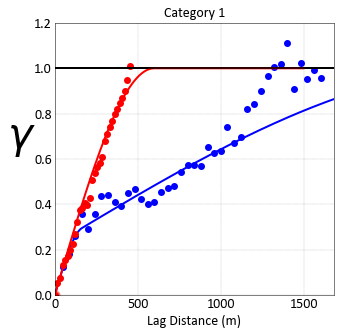

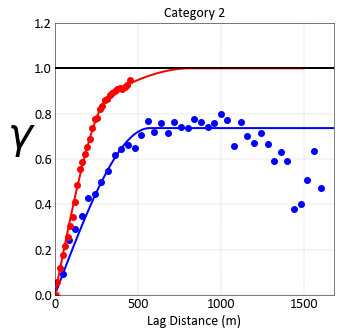

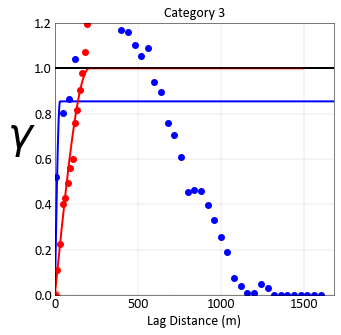

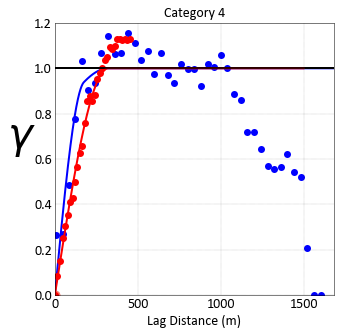

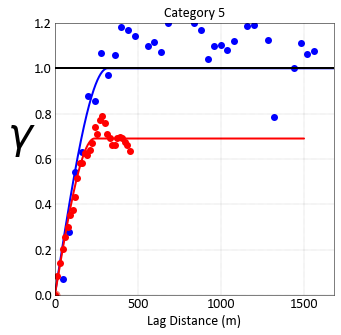

In [10]:
for g in [1,2,3,4,5]:
    varfl = gs.DataFile('Outputs/sisim_out_fl_{}.out'.format(g))
    modelfl=gs.DataFile('Outputs/sisim_cpmodel_file_out_{}.out'.format(g))
    _ = gs.variogram_plot(varfl, index=1, title='Category {}'.format(g), grid=True, ms=7, figsize=(5,5), color='blue')
    gs.variogram_plot(modelfl, index=1, experimental=False, ax= _, lw=2, color='blue', label="omni horizontal", )
    gs.variogram_plot(varfl, index=2, ax= _, grid=True, ms=7, color='red')
    gs.variogram_plot(modelfl, index=2, experimental=False, ax= _, output_file='images/sisim_var_{}.png'.format(g), lw=2, color='red', label="vertical")

Defining grid

In [11]:
grid = cp.infergriddef(blksize=(25,25,15), databuffer=0)

In [12]:
grid

Pygeostat GridDef:
68 12.5 25.0 
52 12.5 25.0 
100 7.5 15.0

indicator simulation

In [13]:
def varg(varg_file):
    f = open(varg_file, "r")
    varstr = f.readlines()
                
    return ''.join(varstr)

In [14]:
nreals = 10

In [15]:
sisimpar = '''
                  Parameters for SISIM
                  ********************

START OF PARAMETERS:
0                             -1=continuous(cdf), 0=categorical(pdf)
5                             -number thresholds/categories
1 2 3 4 5                     -thresholds / categories
{gl1} {gl2} {gl3} {gl4} {gl5}                     -global cdf / pdf
{datafl}                      -file with data
2   3   4   5                 -   columns for X,Y,Z, and variable
direct.ik                     -file with soft indicator input
1   2   0   3 4 5 6 7         -   columns for X,Y,Z, and indicators
0                             -   Markov-Bayes simulation (0=no,1=yes)
0.61  0.54  0.56  0.53  0.29  -      calibration B(z) values
-1.0e21    1.0e21             -trimming limits
0.0   30.0                    -minimum and maximum data value
1      0.0                    -   lower tail option and parameter
1      1.0                    -   middle     option and parameter
1     30.0                    -   upper tail option and parameter
cluster.dat                   -   file with tabulated values
3   0                         -      columns for variable, weight
0                             -debugging level: 0,1,2,3
Outputs/sisim.dbg                     -file for debugging output
{outfl}                     -file for simulation output
{nreals}                             -number of realizations
{griddef}
{seed}                         -random number seed
12                             -maximum original data  for each kriging
12                            -maximum previous nodes for each kriging
1                             -maximum soft indicator nodes for kriging
1                             -assign data to nodes? (0=no,1=yes)
0     3                       -multiple grid search? (0=no,1=yes),num
0                             -maximum per octant    (0=not used)
1000 1000 1000
0 0 0
68    52    100                -size of covariance lookup table
0    2.5                      -0=full IK, 1=median approx. (cutoff)
1                             -0=SK, 1=OK
{var1}
{var2}
{var3}
{var4}
{var5}
'''

sisimpars = {
    'seed':str(gs.rseed()),
    'datafl':cp.flname,
    'griddef':grid,
    'outfl':'Outputs/ind_sim.out',
    'var1':varg('Outputs/sisim_cpvar_model_{}.out'.format(1)),
    'var2':varg('Outputs/sisim_cpvar_model_{}.out'.format(2)),
    'var3':varg('Outputs/sisim_cpvar_model_{}.out'.format(3)),
    'var4':varg('Outputs/sisim_cpvar_model_{}.out'.format(4)),
    'var5':varg('Outputs/sisim_cpvar_model_{}.out'.format(5)),
    'gl1':np.sum(cp['Cat']==1)/len(cp['Cat']),
    'gl2':np.sum(cp['Cat']==2)/len(cp['Cat']),
    'gl3':np.sum(cp['Cat']==3)/len(cp['Cat']),
    'gl4':np.sum(cp['Cat']==4)/len(cp['Cat']),
    'gl5':np.sum(cp['Cat']==5)/len(cp['Cat']),
    'nreals':nreals
}

sisim = gs.Program(program='SISIM/sisim', parstr='Outputs/sisim.par')

sisim.run(parstr=sisimpar.format(**sisimpars))

Calling:  ['SISIM/sisim', 'temp']

 SISIM Version: 3.000

  variable type (1=continuous, 0=categorical)=            0
  number of thresholds / categories =            5
  thresholds / categories =    1.000000       2.000000       3.000000    
   4.000000       5.000000    
  global cdf / pdf        =   0.2567155      0.4679487      6.7460321E-02
  0.1449939      6.2881567E-02
  data file = data/Coper_mod.dat                      
  input columns =            2           3           4           5
  soft data file = direct.ik                               
  trimming limits       -1.0000000E+21  1.0000000E+21
  data limits (tails)    0.0000000E+00   30.00000    
  lower tail =            1  0.0000000E+00
  middle =            1   1.000000    
  upper tail =            1   30.00000    
  file for tab. quant. cluster.dat                             
  columns for vr wt =            3           0
  debugging level =            0
  debugging file = Outputs/sisim.dbg                       
  

   currently on node    130000
   currently on node    140000
   currently on node    150000
   currently on node    160000
   currently on node    170000
   currently on node    180000
   currently on node    190000
   currently on node    200000
   currently on node    210000
   currently on node    220000
   currently on node    230000
   currently on node    240000
   currently on node    250000
   currently on node    260000
   currently on node    270000
   currently on node    280000
   currently on node    290000
   currently on node    300000
   currently on node    310000
   currently on node    320000
   currently on node    330000
   currently on node    340000
   currently on node    350000

 Finished simulation  4
     threshold   1 input cdf = 0.2567 realization cdf = 0.4015
     threshold   2 input cdf = 0.4679 realization cdf = 0.4155
     threshold   3 input cdf = 0.0675 realization cdf = 0.0168
     threshold   4 input cdf = 0.1450 realization cdf = 0.1052
     thres

   currently on node    310000
   currently on node    320000
   currently on node    330000
   currently on node    340000
   currently on node    350000

 Finished simulation  8
     threshold   1 input cdf = 0.2567 realization cdf = 0.4077
     threshold   2 input cdf = 0.4679 realization cdf = 0.3979
     threshold   3 input cdf = 0.0675 realization cdf = 0.0248
     threshold   4 input cdf = 0.1450 realization cdf = 0.1013
     threshold   5 input cdf = 0.0629 realization cdf = 0.0683

 Summary of order relations: 
     threshold 1 number =  82599 average =   0.0516 maximum =   5.3068
     threshold 2 number =  72845 average =   0.0531 maximum =   0.5374
     threshold 3 number =  25631 average =   0.0488 maximum =   0.8209
     threshold 4 number =  65014 average =   0.0412 maximum =   0.4991
     threshold 5 number =  40687 average =   0.0390 maximum =   0.3698

 total of          16.220362% with average of   0.0476
 
  Working on realization number:            9
   currently on

Loading simulation

In [16]:
sisim = gs.DataFile('Outputs/ind_sim.out')

In [17]:
sisim_vals = np.reshape(sisim.data.values, (grid.count(), nreals), order='F')
sisim_pd = pd.DataFrame(columns=['real {}'.format(c) for c in range(nreals)], data=sisim_vals)

In [18]:
sisim_pd.head()

,real 0,real 1,real 2,real 3,real 4,real 5,real 6,real 7,real 8,real 9
0,4.0,4.0,4.0,4.0,1.0,1.0,4.0,1.0,4.0,1.0
1,4.0,4.0,4.0,4.0,1.0,4.0,4.0,1.0,4.0,4.0
2,4.0,4.0,4.0,4.0,1.0,4.0,1.0,1.0,4.0,1.0
3,4.0,4.0,4.0,4.0,1.0,4.0,1.0,1.0,4.0,4.0
4,4.0,4.0,4.0,4.0,1.0,4.0,1.0,1.0,4.0,4.0


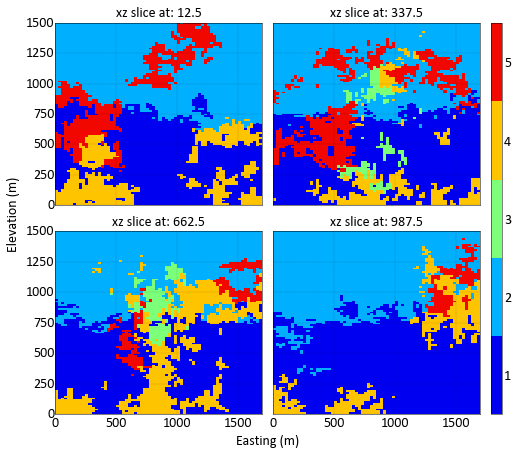

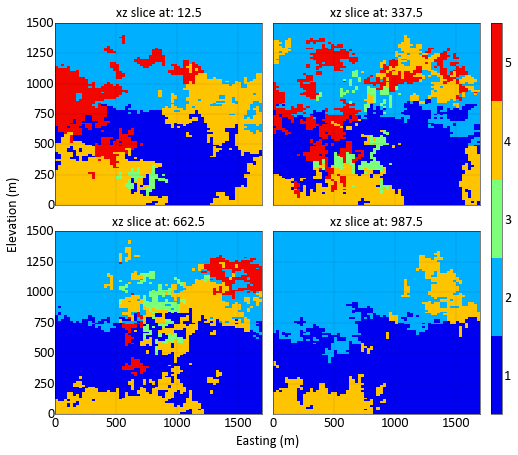

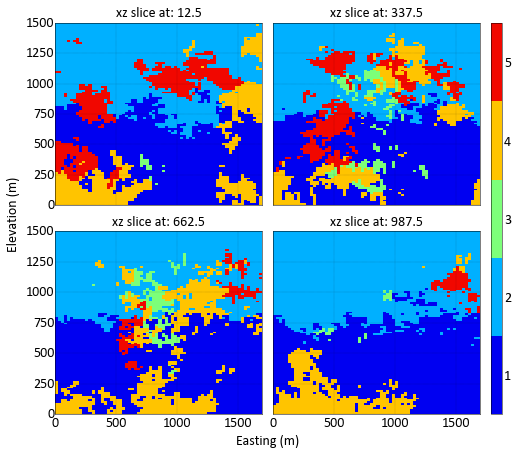

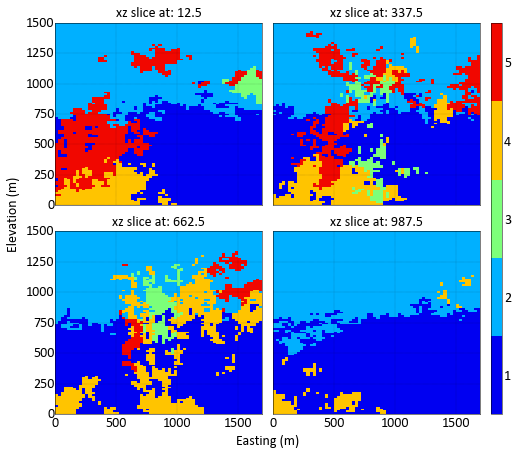

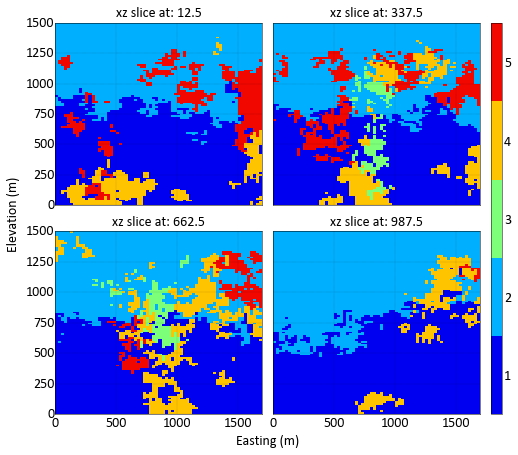

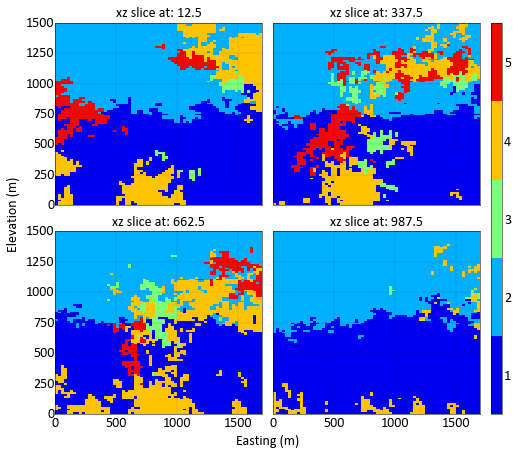

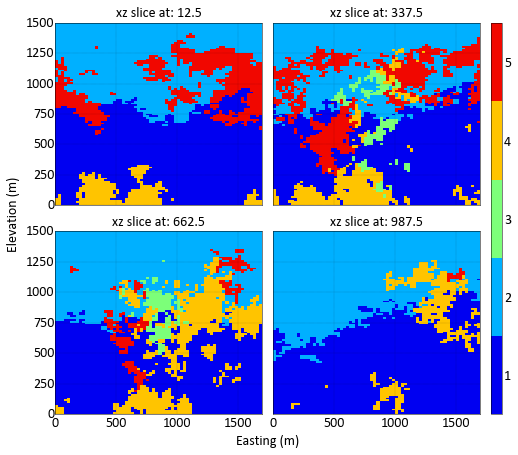

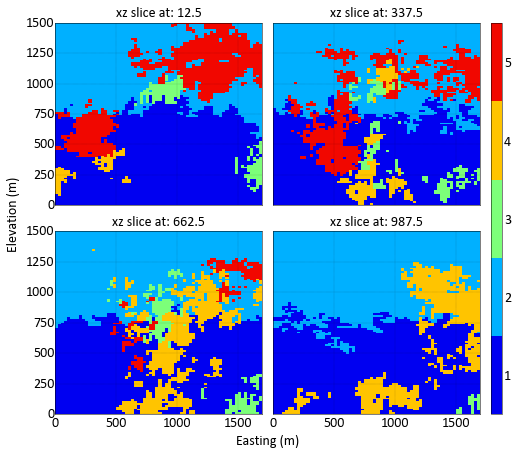

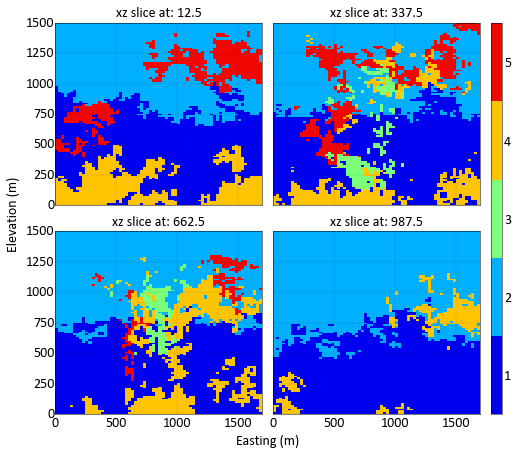

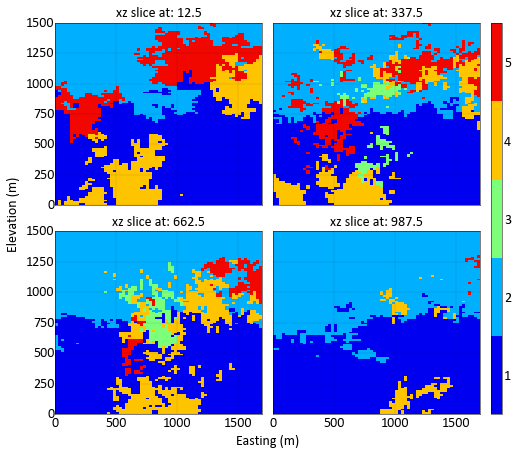

In [19]:
for i in range(nreals):
    _ = gs.grid_slice_plot(sisim_pd['real {}'.format(i)], griddef=grid, cmap='jet', grid=True, orient='xz', output_file='images/sisim_real_{}.png'.format(i))

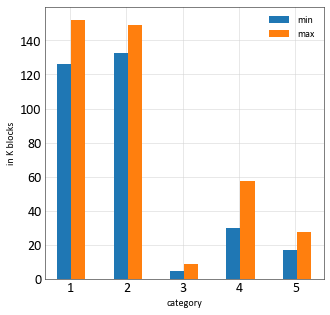

In [20]:
volume_diff(sisim_pd, output='images/ssim_bars.png')

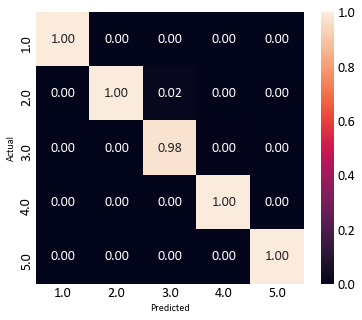

In [21]:
backflag(x=cp['X'], y=cp['Y'], z=cp['Z'], prop=cp['Cat'], grid=grid, reals=sisim_pd, output='images/ssim_backflag.png')

In [22]:
shanon_entropy = entropy(sisim_pd)

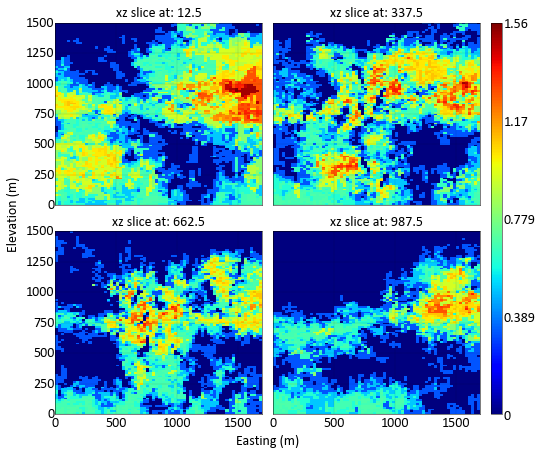

In [23]:
_ = gs.grid_slice_plot(shanon_entropy, griddef=grid, cmap='jet', grid=True, orient='xz', output_file='images/sisim_entropy.png')